Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-6eb79d4a92eb>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Class'] = df['Class'].replace({'+': 1, '-': 0})  # Mengubah nilai 'Class' dari '+' menjadi 1 dan '-' menjadi 0
<ipython-input-2-6eb79d4a92eb>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
<ipython-input-2-6eb79d4a92eb>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Average Accuracy: 0.9549321063853664
Average Precision: 0.9824844940634414
Average Recall: 0.9164971751412428
Average F1 Score: 0.9478384003154454
Average Specificity: 0.9864124398370974
Average AUC: 0.9514548074891701


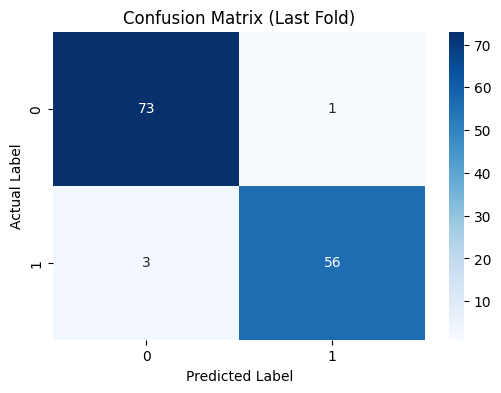

In [2]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier  # Import XGBoost
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive (if running in Google Colab)
drive.mount('/content/drive')

# Define the file path
file_path = 'dataset/crx_data.xlsx'
df = pd.read_excel(file_path)

# Step 1: Pra-pemrosesan data
df['Class'] = df['Class'].replace({'+': 1, '-': 0})  # Mengubah nilai 'Class' dari '+' menjadi 1 dan '-' menjadi 0
df['A2'] = pd.to_numeric(df['A2'], errors='coerce')  # Konversi kolom A2 ke numerik
df['A14'] = pd.to_numeric(df['A14'], errors='coerce')  # Konversi kolom A14 ke numerik
df.dropna(inplace=True)  # Menghapus nilai yang hilang
df.drop_duplicates(inplace=True)  # Menghapus duplikasi

# Encoding categorical features
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Step 2: Apply MinMaxScaler to the numerical columns
scaler = MinMaxScaler()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Step 3: GMM for Clustering (assuming 3 clusters as an example)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(df[numerical_columns])
df['gmm_label'] = gmm_labels

# Step 4: Ensure target 'Class' is an integer
df['Class'] = df['Class'].astype(int)

# Step 5: Add GMM labels to the feature set
X = df.drop(columns=['Class'])
y = df['Class']

# Initialize StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
specificities = []

# Cross-validation loop
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Identify numerical columns from X_train for scaling
    numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

    # Standardize the training and test data
    scaler = MinMaxScaler()
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # Train the XGBoost model
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_model.predict(X_test)

    # Calculate metrics for this fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    spec = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    # Store metrics
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    specificities.append(spec)

# Calculate and print average metrics across all folds
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average Precision: {np.mean(precisions)}")
print(f"Average Recall: {np.mean(recalls)}")
print(f"Average F1 Score: {np.mean(f1_scores)}")
print(f"Average Specificity: {np.mean(specificities)}")
print(f"Average AUC: {np.mean(roc_aucs)}")

# Plotting Confusion Matrix for the last fold
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Last Fold)')
plt.show()
